In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
sys.path.append("../")

import torch
from torch import nn
import torch.nn.functional as F

from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config
# from nupic.research.frameworks.pytorch.models.le_sparse_net import (
#     LeSparseNet
# )
from nupic.research.frameworks.continuous_learning.utils import clear_labels
from exp_lesparse import LeSparseNet

from nupic.torch.modules import (
    Flatten,
    KWinners,
    KWinners2d,
    SparseWeights,
    SparseWeights2d,
)

from nupic.research.frameworks.pytorch.model_utils import evaluate_model
from nupic.research.frameworks.continuous_learning.dendrite_layers import DendriteLayer, DendriteInput, DendriteOutput
# from nupic.research.frameworks.continuous_learning.utils import ADA_fun

import matplotlib.pyplot as plt

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
x = torch.randn(8,32).cuda()
d = DendriteLayer(32,10, 2).cuda()
d(x)

tensor([[ 4.2825e-02,  4.9733e-04,  1.3175e-04, -2.4124e-02,  2.6152e-03,
          4.1738e-02, -5.4527e-04,  2.3421e-02, -2.7123e-01, -1.9934e-01],
        [ 1.0092e-01,  2.4786e-04, -5.8615e-04,  4.2249e-02,  7.8171e-02,
         -3.1026e-05,  1.1484e-01,  9.2927e-02,  6.3322e-03, -2.5541e-01],
        [ 2.3653e-01, -4.8790e-02, -6.3270e-03, -7.1225e-02, -1.6917e-01,
         -3.9593e-02,  1.7978e-02,  1.6611e-01,  2.7940e-04,  4.6764e-04],
        [ 2.0023e-01,  1.3052e-04,  2.6995e-01,  8.2714e-02, -2.0245e-01,
          7.9775e-02, -8.6057e-04, -1.1916e-02, -6.2298e-03, -7.8432e-02],
        [-7.3724e-02,  3.8356e-05,  8.1817e-02,  4.1583e-03,  2.3288e-01,
         -2.3185e-02,  1.4477e-01, -1.2818e-04, -2.2759e-01, -1.2235e-02],
        [-2.5788e-02, -4.6769e-03, -4.3951e-03,  4.8498e-02, -8.9261e-02,
         -2.5556e-01,  2.0215e-01, -1.3576e-02, -4.6462e-02, -3.7759e-02],
        [ 6.4369e-02, -6.2462e-02, -4.1024e-02,  1.0752e-01,  1.3158e-01,
         -6.2238e-02, -7.2190e-0

In [3]:
config_file = "../experiments.cfg"
with open(config_file) as cf:
    config_init = parse_config(cf)
    
cnn_pct_on = (0.25, 0.125) # default
cnn_weight_sparsity = (0.3, 0.2) # default

cnn_out = (64,64)

def adjust_sparsity(layer_size, pct_on):
    return max(pct_on/(layer_size/64), 0.02)

exp = "sparseCNN2"
config = config_init[exp]
config["name"] = exp
config["seed"] = np.random.randint(0,200)
config["cnn_out_channels"] = (cnn_out[0], cnn_out[1])
config["cnn_percent_on"] = (adjust_sparsity(cnn_out[0],cnn_pct_on[0]), adjust_sparsity(cnn_out[1], cnn_pct_on[1]))
config["cnn_weight_sparsity"] = (adjust_sparsity(cnn_out[0],cnn_weight_sparsity[0]),
                                 adjust_sparsity(cnn_out[1],cnn_weight_sparsity[1]))
config["batch_size"] = 32

# config["boost_strength"] = 0.0
# config["boost_strength_factor"] = 0.0
# config["duty_cycle_period"] = 4000

experiment = ContinuousSpeechExperiment(config)

1.5
1.5
Creating optimizer with learning rate= 0.05


In [3]:
experiment.train_entire_dataset(1)
experiment.test()

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
train_inds = np.arange(1,11).reshape(5,2)
layer_type = "kwinner"
for j in range(len(train_inds)):
    experiment.train(1,train_inds[j],
                    freeze_output=False,
                    layer_type=layer_type,
                    output_indices=clear_labels(train_inds[j]))

In [ ]:
fc = experiment.get_forgetting_curve()
plt.imshow(fc)

In [ ]:
plt.plot(fc,'o');

In [6]:
a =np.vstack(experiment.running_accuracy)

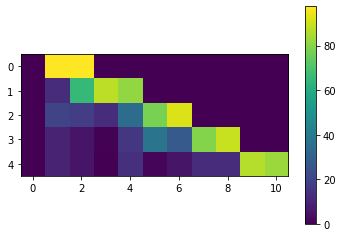

In [10]:
plt.imshow(a)
plt.colorbar();

In [8]:
b = np.vstack([np.roll(a[i,:], 8-2*i) for i in range(a.shape[0])])

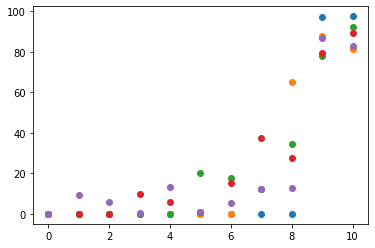

In [9]:
plt.plot(b.T,'o')

In [ ]:
torch.autograd.function